#### Алгоритм нахождения границ с использованем "Мягкое" подавление немаксимумов

Порядок Алгоритма 
1. Подавление шума;
2. Расчет градиента;
3. Не максимальное подавление;
4. Двойной порог;
5. Отслеживание краев по гистерезису.

In [1]:
import cv2
import numpy  as np 
import pandas as pd
import matplotlib.pylab as plt
from scipy import ndimage

In [2]:
def view(img, x=7, y=7, _cmap='autumn_r'):
    plt.figure(figsize=(x, y))
    plt.imshow(img, cmap=_cmap)
    plt.show()
    
def gradient_magnitude(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return G, theta


def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z


def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res, weak, strong


def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

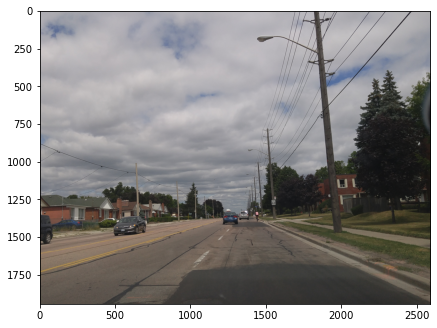

In [3]:
image = cv2.imread('./Data/9645_16.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
view(image)

In [4]:
gray = cv2.cvtColor(image.copy(), cv2.COLOR_RGB2GRAY)

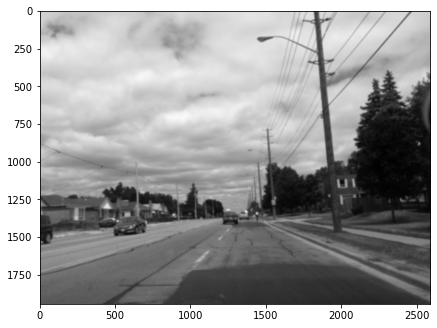

In [5]:
blur = cv2.GaussianBlur(gray,(33,33),cv2.BORDER_DEFAULT)
view(blur, _cmap='gray')

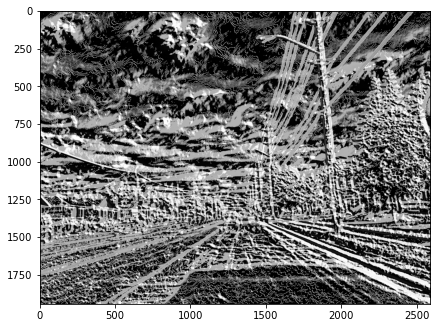

In [6]:
gradient = gradient_magnitude(blur)
view(gradient[0].astype('int'), _cmap='gray')

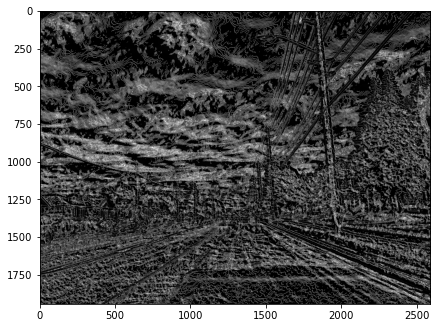

In [7]:
g = non_max_suppression(gradient[0], gradient[1])
view(g, _cmap='gray')

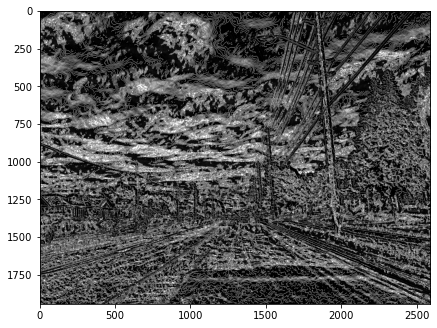

In [8]:
thr = threshold(g)
view(thr[0], _cmap='gray')

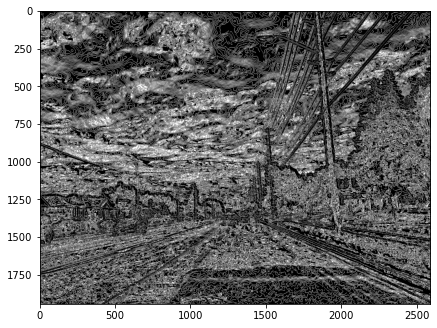

In [9]:
h = hysteresis(thr[0], thr[1], thr[2])
h = h.astype('uint8')
view(h, _cmap='gray')